## 1. Connect to google drive

In [1]:
# from google.colab import drive

# drive.mount('/gdrive')

# filepath = '/gdrive/My Drive/path'

In [2]:
# zip_path = f"{filepath}/data.zip"
# !cp "{zip_path}" .
# !unzip -q data.zip -d ./data
# !rm data.zip

In [3]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import urllib
import glob
import math
import matplotlib.pyplot as plt
import random
import torchvision
import torchvision.transforms as transforms
import easydict
import itertools
import albumentations
import albumentations.pytorch
import time
import cv2
import itertools

from PIL import Image
from torch.utils.tensorboard import SummaryWriter
# !pip install -U tensorboardcolab
# from tensorboardcolab import TensorBoardColab

random_seed = 777
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# !rm /etc/localtime
# !ln -s /usr/share/zoneinfo/Asia/Seoul /etc/localtime

# Setting Hyperparameters

In [4]:
args = easydict.EasyDict({
    'name': 'ResNet_useall', #model name
    'train': True,
    'batch_size': 256,       # input batch size
    'n_epochs': 200,         # number of epochs
    'n_workers': 2,         # number of data loading workers
    'optimizer': 'adam', #optimizer (adam or sgd)
    'learning_rate': 0.002, # learning rate
    'beta1': 0.9,           # beta 1 for adam
    'beta2': 0.999,         # beta 2 for adam
    'momentum': 0.9,        # momentum for SGD
    'weight_decay': 5e-4,   # weight_decay for SGD
    'step_size': 25,        # step size
    'gamma': 0.8,           # gamma
    'in_data_file': 'data/', # data directory
    'model': '',      # model path reload
    'out_dir': 'outputs/'    # output directory
})
args.out_dir = args.out_dir + '{}_{}_lr{}'.format(args.name, args.optimizer, args.learning_rate)

In [5]:
train_path = "./data/train_images"
files = glob.glob(f"{train_path}/*.jpg")
csv = './data/train.csv'
csv = pd.read_csv(csv)
train_ratio = 0.8
# input_size = (224, 224)
input_size = (240, 240)

num_sample = 3000

batch_size = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


**Outliers**

In [6]:
from common import unusual, outliers

unusual = unusual
outliers = outliers

In [7]:
drop_index = [csv[csv['image_id'] == id].index.values[0] for id in (unusual + outliers)]
csv = csv.drop(drop_index)
csv = csv.reset_index(drop=True)

img_count = [len(csv[csv['label'] == i]) for i in range(5)]
print("number of images")
print(img_count)

n_data = len(csv)
n_val = 200 * 5
n_train = n_data - n_val
print(n_train, n_val)

number of images
[1087, 2107, 2379, 13137, 2565]
20275 1000


## 2. DataLoader


In [8]:
from utils import validation_sampler

train_idx, valid_idx = validation_sampler(root=train_path, n_data=n_data, n_val=n_val, csv=csv)

## Data augmentation

In [9]:
"""Rotation"""
transform_rotation = albumentations.Compose([ albumentations.RandomRotate90(),
                                        ])

"""Flip"""
transform_flip = albumentations.Compose([ albumentations.HorizontalFlip(),
                                      albumentations.VerticalFlip(),
                                    ])

"""RandomResizeCrop"""
transform_crop = albumentations.Compose([ albumentations.RandomResizedCrop(300, 300),
                                    ])

"""PCA"""
transform_PCA = albumentations.Compose([albumentations.FancyPCA(p=0.5)])

train_transform=albumentations.Compose([
                                    transform_crop,
                                    albumentations.Resize(input_size[0], input_size[1]),
                                    transform_rotation,
                                    transform_flip,
                                    transform_PCA,
                                    albumentations.pytorch.ToTensorV2()
                              ])

test_transform=albumentations.Compose([
                                    albumentations.Resize(input_size[0], input_size[1]),
                                    albumentations.pytorch.ToTensorV2()
                              ])

In [10]:
from utils import cassava_dataset_albu

train_dataset = cassava_dataset_albu(root=train_path, csv=csv,
                               train_test="train",
                               idx=train_idx,
                               transform=train_transform)

valid_dataset = cassava_dataset_albu(root=train_path, csv=csv,
                               train_test="valid",
                               idx=valid_idx,
                               transform=test_transform)
'''
Use all data
'''
# train_loader = torch.utils.data.DataLoader(train_dataset,
#                                            batch_size=batch_size,
#                                            shuffle=True,
#                                            drop_last=True
#                                           )
# valid_loader = torch.utils.data.DataLoader(valid_dataset,
#                                            batch_size=batch_size,
#                                            shuffle=False,
#                                            drop_last=True
#                                            )

'''
Use arbitary sampled data
'''
num_of_each_sample_train = num_sample

weights = 1 / torch.Tensor(img_count)
weights_all = torch.Tensor([weights[csv.iloc[i, 1]] for i in range(sum(img_count))])
train_sampler = torch.utils.data.sampler.WeightedRandomSampler(weights_all[train_idx], 5*num_of_each_sample_train)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=args.batch_size,
                                           sampler=train_sampler,
                                           shuffle=False,
                                           num_workers=args.n_workers,
                                           drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=args.batch_size,
                                           shuffle=False,
                                           num_workers=args.n_workers,
                                           drop_last=False)

Text(0.5, 0.98, 'Sample images')

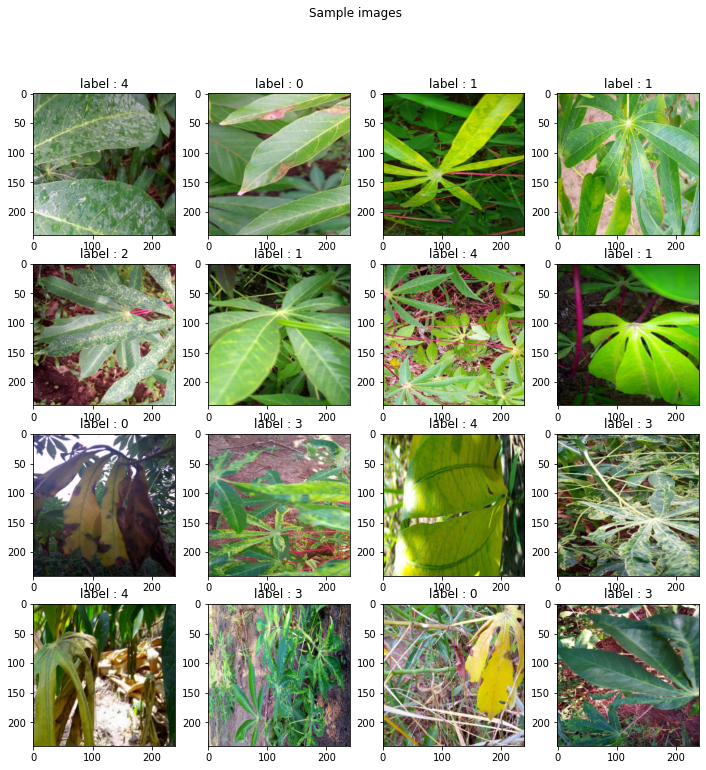

In [11]:
(sample_batch, sample_label) = next(iter(train_loader))

is_norm = False

fig = plt.figure(figsize=(12, 12))
for i in range(4):
    for j in range(4):
        fig.add_subplot(4, 4, (i * 4 + j + 1))
        if is_norm:
            plt.imshow(torch.clamp((sample_batch[i*4+j].permute(1,2,0) * 255).int(), 0, 255))
        else:
            plt.imshow(sample_batch[i*4+j].permute(1, 2, 0))
        plt.title(f"label : {sample_label[i*4+j]}")
plt.suptitle("Sample images")

# Training Definition

In [12]:
from utils import run_train, run_eval, run_epoch, run_epoch_train_and_test

def train_model(args, train_dataset, train_dataloader, test_dataset, 
                test_dataloader, net):
    if args.optimizer == 'adam':
        optimizer = torch.optim.Adam(
            net.parameters(), lr=args.learning_rate,
            betas=(args.beta1, args.beta2))
    elif args.optimizer == 'sgd':
        optimizer = torch.optim.SGD(
            net.parameters(), lr=args.learning_rate, momentum=args.momentum, 
            weight_decay=args.weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=args.step_size, gamma=args.gamma)

    print(args)
    print()
    if torch.cuda.is_available():
        net.to(device)

    if args.model != '':
        print(args.model, "Loaded")
        net.load_state_dict(torch.load(args.model))

    if not os.path.exists(args.out_dir):
        os.makedirs(args.out_dir)
    
    if args.train:
        writer = SummaryWriter(args.out_dir)
        %load_ext tensorboard
        %tensorboard --logdir={args.out_dir} --port 9999
        best_acc = 0.0
        for epoch in range(63, args.n_epochs):
            test_loss, test_acc = run_epoch_train_and_test(train_dataset, 
                train_dataloader, test_dataset, test_dataloader, net, 
                optimizer, args, epoch, writer)

            if test_acc > best_acc:
                best_acc = test_acc

                model_file = os.path.join(
                    args.out_dir, '{}_epoch{:d}.pt'.format(args.name, epoch + 1))
                torch.save(net.state_dict(), model_file)
                print("Saved '{}'.".format(model_file))

            scheduler.step()
        print("best: {:.4f}".format(best_acc))
        writer.close()
    else:
        run_epoch_train_and_test(train_dataset, train_dataloader, test_dataset, test_dataloader)

# Model Definition

In [13]:
net = torchvision.models.resnet50(pretrained = False)

# Train

In [14]:
# train_model(args, train_dataset, train_loader, valid_dataset, valid_loader, net)

## Confusion Matrix

In [15]:
best_model = torch.load(glob.glob(args.out_dir  + "/*.pt")[-1])
net.load_state_dict(best_model)
net = net.to(device)
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
from utils import get_all_preds, get_num_correct

preds, labels = get_all_preds(net, valid_loader)
preds_correct = get_num_correct(preds, labels)

Normalized confusion matrix
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


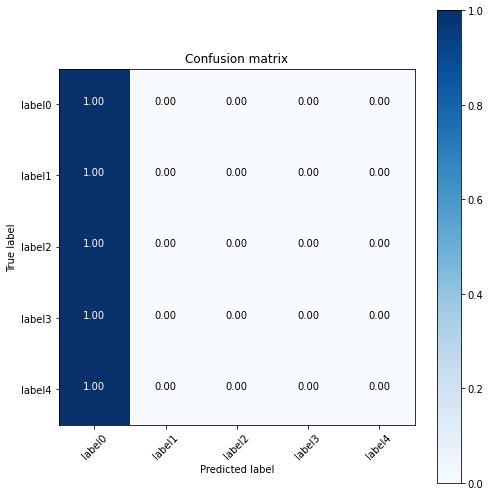

In [17]:
from utils import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

labels = labels.to('cpu')
preds = preds.to('cpu')
cm = confusion_matrix(labels, preds.argmax(dim=1))
plt.figure(figsize=(7, 7))
plot_confusion_matrix(cm, ['label0', 'label1', 'label2', 'label3', 'label4'], normalize=True)
plt.savefig(args.out_dir + '/confusion_matrix.png')